# A standardized simulation procedure

## Import packages

In [3]:
from BEVCommunity import BEVCommunity
import numpy as np
import pandas as pd
from random import randint
from PIL import Image

## Understand the aimed energy network and model configuration
Please review the figures and understand the aimed energy network and how BEVPro works

The framework of the aimed energy network in this version


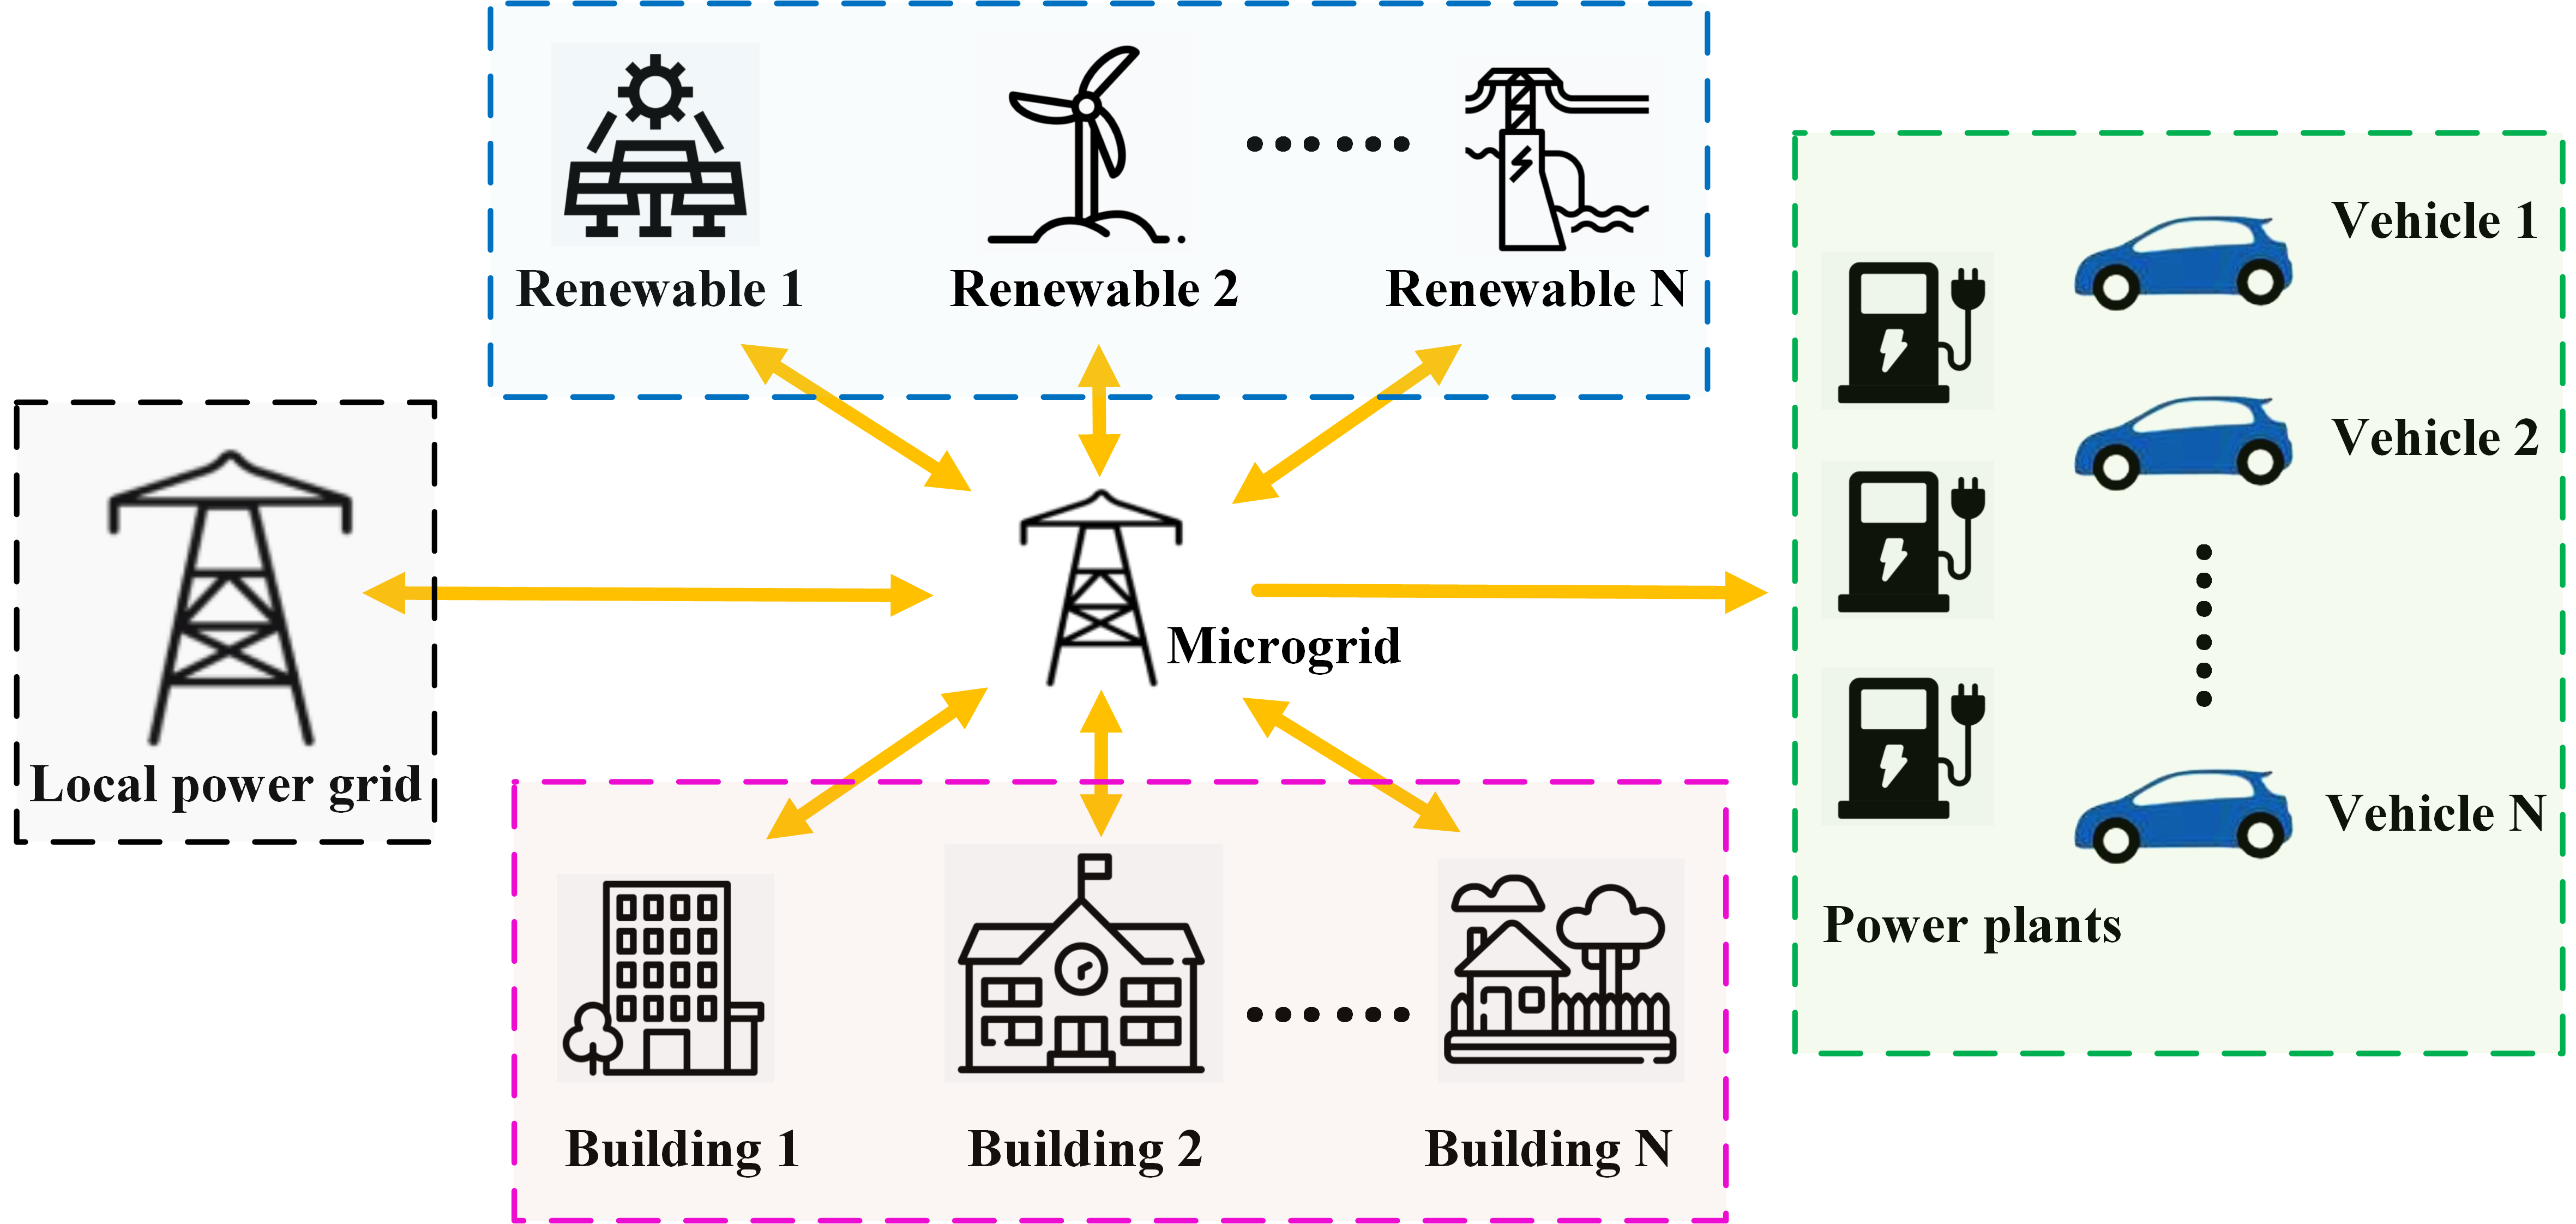

In [2]:
print('The framework of the aimed energy network in this version')
display(Image.open('inputs/Platform BEVPro.png'))

## Load input files
Include building energy demands, renewable production, vehicle parking schedules and parameters, and power plant quantity for charging vehicles

In [ ]:
"""
Before loading input files, please make sure the parameters in each input file in folder 'input' are correctly entered:

1. Building files (like building1.csv):
    Building electric demands of 8760 hours (one year).The first column is the hour index, and the second column is the hourly power.
    
2. Renewable files (like renewable1.csv):
    Renewable power values of 8760 hours (one year).The first column is the hour index, and the second column is the hourly power.
    
3. Vehicle schedule file (vehicle_atHomeSchd.csv):
    Parking schedules of electric vehicles. The first column is the hour index, and the other columns are different parking schedules: 1 means parking at home, and 0 means not at home.
    
4. Vehicle files (like vehicle1.csv):
    key parameters of electric vehicles:
    -- cruiseEff: electricity consumption per unit distance during transportation, unit in kWh/km.
    -- maxChargingCapacity: maximum charging capacity, kW.
    -- charEff: charging efficiency
    -- maxDischargingCapacity: maximum discharging capacity, kW.
    -- discEff: discharging efficiency
    -- batteryCapacity: maximum battery capacity of a electric vehicle, unit in kWh.
    -- dist_mean_wd: mean daily cruise distance of a vehicle during working days, unit in km.
    -- dist_std_wd: standard deviation of daily cruise distance of a vehicle during working days, unit in km.
    -- dist_mean_nwd: mean daily cruise distance of a vehicle during non-working days, unit in km
    -- dist_std_nwd: standard deviation of daily cruise distance of a vehicle during non-working days, unit in km.
    -- parkSchd_wd: vehicle parking schedule for working days, corresponding to the column index of vehicle_atHomeSchd.csv.
    -- parkSchd_nwd: vehicle parking schedule for non-working days, corresponding to the column index of vehicle_atHomeSchd.csv.
    
5. powerplant_num:
    power plant quantity for charging vehicles
"""

In [2]:
"""
Note:
1. In building_list, for ('inputs/building1.csv', 10), 'inputs/building1.csv' is the building demand file; '10' is the quantity of buildings
   which have the same demand profile as that in the building demand file.

2.In renewable_list, for ('inputs/renewable1.csv', 10), 'inputs/renewable1.csv' is the renewable production file; '10' is the quantity of renewable sources
   which have the same production profile as that in the renewable production file.

3. In vehicle_list, for ('inputs/vehicle1.csv', 10), 'inputs/vehicle1.csv' is the vehicle parameter file, and '10' is the quantity of electric vehicles which have
   the same parameters as those in the vehicle parameter file.
"""

building_list = [('inputs/building1.csv', 10), ('inputs/building2.csv', 10), ('inputs/building3.csv', 10)]
renewable_list = [('inputs/renewable1.csv', 10), ('inputs/renewable2.csv', 10), ('inputs/renewable3.csv', 10)]
vehicle_list = ['inputs/vehicle_atHomeSchd.csv', ('inputs/vehicle1.csv', 3), ('inputs/vehicle2.csv', 3), ('inputs/vehicle3.csv', 3)]
battery_info = 'inputs/battery_info.csv'
powerplant_num = 30

## Check objects and initiate their states
check the key energy-related variables and then initiate BEVpro environment

In [26]:
# check the object names
env = BEVCommunity(building_list, renewable_list, vehicle_list, battery_info, powerplant_num)
env.obs_names

c:\users\yingdong\gym\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


['buildingLoad',
 'reGeneration',
 'battery_left',
 'battery_spare',
 'vehicle_park_0',
 'vehicle_park_1',
 'vehicle_park_2',
 'vehicle_park_3',
 'vehicle_park_4',
 'vehicle_park_5',
 'vehicle_park_6',
 'vehicle_park_7',
 'vehicle_park_8',
 'vehicle_max_dist_0',
 'vehicle_max_dist_1',
 'vehicle_max_dist_2',
 'vehicle_max_dist_3',
 'vehicle_max_dist_4',
 'vehicle_max_dist_5',
 'vehicle_max_dist_6',
 'vehicle_max_dist_7',
 'vehicle_max_dist_8',
 'vehicle_SOC_0',
 'vehicle_SOC_1',
 'vehicle_SOC_2',
 'vehicle_SOC_3',
 'vehicle_SOC_4',
 'vehicle_SOC_5',
 'vehicle_SOC_6',
 'vehicle_SOC_7',
 'vehicle_SOC_8']

In [6]:
# check the action names
env.action_names

['vehicle_0',
 'vehicle_1',
 'vehicle_2',
 'vehicle_3',
 'vehicle_4',
 'vehicle_5',
 'vehicle_6',
 'vehicle_7',
 'vehicle_8']

In [4]:
# Check the initial state of objectives
state = env.reset()
state

[6.0,
 0.0,
 0,
 1000.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 50.0,
 50.0,
 50.0,
 40.0,
 40.0,
 40.0,
 30.0,
 30.0,
 30.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

In [27]:
# Check the time step, unit in hour
env.stepLenth
step_h = env.stepLenth/3600
step_h

1.0

## Deploy energy management strategies in Agent

In [12]:

def check_and_charge(state):
    """
    Vehicles will be charged only when parked in the area with the proposed energy network.
    
    Args:
        - threshold_lower: the lowerest state of charge (SOC) of activating charging a parked vehicle.
                     0.1 means that for a parked vehicle, when the battery electricity is less than 10% of the battery capacity, the vehicle
                     requires to activate charging. The charging activation will be decided by the selected charging mode. Once the charging
                     is activated, the vehicle will be continuously charged until the battery SOC reaches the upper threshold, the vehicle
                     leaves, or the charging activity is deactivated.

        - threshold_upper: the upper threshold of battery charging, i.e., the highest SOC when stopping charging a parked vehicle.
                     1 means that the vehicle charging will be stopped when the battery electricity reaching 100% of the battery capacity
                     unless the vehicle leaves before its battery is full.
    """
    global currentHour, preAction, vehicleSOC
    
    threshold_lower = 0.1
    threshold_upper = 1       
    
    # Check states of vehicles and decide whether charge vehicles or not
    def normal_charge(vehicleSOC, preAction):         
        """
        This function customizes the normal charging mode, which activates the charging of a parked vehicle whenever the battery SOC is lower
        than the lower threshold.
    
        Args:
            - charging_power: the rated vehicle charging power, unit in kW.
        """
        nonlocal threshold_lower, threshold_upper
        charging_power = 20
    
    #----------------------------------------------------
    # Do not change the code between the two dashed lines         
        vehicleSOC = round(vehicleSOC,2)
        if vehicleSOC < threshold_lower or (preAction > 0 and vehicleSOC < threshold_upper):
            action = charging_power
        else:
            action = 0
        return action
    # Do not change the code between the two dashed lines
    #----------------------------------------------------
     
    
    def scheduled_charge(vehicleSOC,currentHour,preAction):
        """
        This function customizes the scheduled charging mode, which only allows vehicle charging activation during certain hours of a day.
    
        Please note other unscheduled hours of a day have zero charging power.
    
        Args:
            - power1: the maximum charging power during period 1, unit in kW.
            - period1: the first period of a day with the charging power at power1.
            - power2: the maximum charging power during period 2, unit in kW.
            - period2: the second period of a day with the charging power at power2.
            - power3: the maximum charging power during period 3, unit in kW.
            - period3: the third period of a day with the charging power at power3.

        """
        nonlocal threshold_lower, threshold_upper 
        
        power1 = 0
        period1 = [7, 8, 9, 17, 18, 19, 20, 21, 22, 23]
        power2 = 20
        period2 = [0, 1, 2, 3, 4, 5, 6]
        power3 = 20
        period3 = [10, 11, 12, 13, 14, 15, 16]
        
    
    #----------------------------------------------------
    # Do not change the code between the two dashed lines 
        vehicleSOC = round(vehicleSOC,2)
        if currentHour in period1 and (vehicleSOC < threshold_lower or (preAction > 0 and vehicleSOC < threshold_upper)):
            action = power1
        elif currentHour in period2 and (vehicleSOC < threshold_lower or (preAction > 0 and vehicleSOC < threshold_upper)):
            action = power2
        elif currentHour in period3 and vehicleSOC < threshold_upper:
            action = power3
        else:
            action = 0

        return action
    # Do not change the code between the two dashed lines 
    #----------------------------------------------------
    
    def responsive_charge(vehicleSOC,currentHour,preAction):
        
        """
        This function customizes the responsive charging mode, which adopts a decreased upper threshold and a reduced power of vehicle
        charging during demand-shortage periods when the grid has limited renewable-produced electricity, and adopts a large charging power
        during renewable-surplus periods when the grid usually has abundant renewable-produced electricity.

        During the renewable-surplus period, the parked vehicles will be charged as long as the battery SOC is lower than the upper threshold.

        Please note other unscheduled hours of a day have zero charging power.

        Args:
            - threshold_upper2: the reduced upper threshold of vehicle charging during demand-shortage periods.
            - power1: the maximum charging power during period 1 (peak hours), unit in kW.
            - period1: the first period of a day with the charging power at power1.
            - power2: the maximum charging power during period 2 (still demand-shortage periods, but not peak hours), unit in kW.
            - period2: the second period of a day with the charging power at power2.
            - power3: the maximum charging power during period 3 (renewable-surplus periods), unit in kW.
            - period3: the third period of a day with the charging power at power3.

        """
        nonlocal threshold_lower, threshold_upper
        
        threshold_upper2 = 0.3

        power1 = 0
        period1 = [7, 8, 9, 17, 18, 19, 20, 21, 22, 23]
        power2 = 5
        period2 = [0, 1, 2, 3, 4, 5, 6]
        power3 = 20
        period3 = [10, 11, 12, 13, 14, 15, 16]
        
     
    #----------------------------------------------------
    # Do not change the code between the two dashed lines
        vehicleSOC = round(vehicleSOC,2)
        if currentHour in period1 and (vehicleSOC < threshold_lower or (preAction > 0 and vehicleSOC < threshold_upper2)):
            action = power1
        elif currentHour in period2 and (vehicleSOC < threshold_lower or (preAction > 0 and vehicleSOC < threshold_upper2)):
            action = power2
        elif currentHour in period3 and vehicleSOC < threshold_upper:
            action = power3
        else:
            action = 0

        return action
    
    mode_1 = normal_charge(vehicleSOC, preAction)
    mode_2 = scheduled_charge(vehicleSOC,currentHour,preAction)
    mode_3 = responsive_charge(vehicleSOC,currentHour,preAction)
    # Do not change the code between the two dashed lines
    #----------------------------------------------------    
    
    """
    Args:
        - action: the selected charging mode. mode_1 for normal charging, mode_2 for scheduled charging, and mode_3 for responsive charging
    """
    
    action = mode_3    
    
    #----------------------------------------------------
    # Do not change the code between the two dashed lines 
    return action
    # Do not change the code between the two dashed lines 
    #----------------------------------------------------

## Simulation setup
Do NOT change anything here

In [13]:
vehicleSOC, preAction, currentHour = 0, 0, 0

def gym_simulate(building_list, renewable_list, vehicle_list, battery_info, powerplant_num):
    '''
    '''
    global vehicleSOC, preAction, currentHour
    env = BEVCommunity(building_list, renewable_list, vehicle_list, battery_info, powerplant_num)
    vehicles_number = len(env.vehicles)
    
    state_data = []
    action_data = []
    reward_data = []
    comment_data = []
    
    state = env.reset()
    #print(env.vehicles)
    for _ in range(env.n_steps):
        ############## Select Action ################### 
        time = env.timeIndex[env.time_step_idx]
        currentHour = time.hour
        actions = []
        SOCs = []
        for vehicle in env.vehicles:
            if action_data == []:
                preAction = 0
            else:
                preAction = action_data[env.time_step_idx-1][env.vehicles.index(vehicle)]
            
            vehiclePark = state[4+env.vehicles.index(vehicle)]
            vehicleSOC = state[4+2*vehicles_number+env.vehicles.index(vehicle)]
            SOCs.append(round(vehicleSOC,2))
            #print(vehiclePark, vehicleSOC)
            if vehiclePark == 1:
                action = check_and_charge(state)    
            else:
                action = 0
            actions.append(action)
        actions = np.array(actions)
        
        if max(actions) > 0:
            print(f'{time}: charge rate: {actions}')
            #print(f'{time}: SOCs: {SOCs}') 
        ############## Simulate ###################
        new_state, rewards, done, comment= env.step(actions)

        state_data.append(state)
        action_data.append(actions)
        reward_data.append(rewards)
        comment_data.append(comment)
        
        state = new_state
        
        if done:
            print('Simulation is done!')
            # actions_data = buffer.action_data()
            states = pd.DataFrame(state_data, columns=env.obs_names, index=env.timeIndex)
            actions = pd.DataFrame(action_data, columns=env.action_names, index=env.timeIndex)
            rewards = pd.DataFrame(reward_data, columns=['gridLoad'], index=env.timeIndex)
            comments = pd.DataFrame(comment_data, columns=['power_batteryCharge','power_batteryDischarge','totalVehicleCharge','totalVehicletoGrid'], index=env.timeIndex)
            # obs_data.to_csv('result_ep{0}.csv'.format(ep))
            
    return states, actions, rewards, comments

## Run simulation
In this version, only the time steps in which the actions of vehicles might appear are shown during the simulation procedure.

In [14]:
states, actions, rewards, comments = gym_simulate(building_list, renewable_list, vehicle_list, battery_info, powerplant_num)

c:\users\yingdong\gym\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


2019-01-01 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-01 12:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-01 13:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-02 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-03 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-04 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-05 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-06 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-01-07 00:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 01:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 02:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 03:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 04:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 05:00:00: charge rate: [5 5 5 0 0 0 0 0 0]
2019-01-07 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-01-07 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-01-07 15:00:00: charge rate: [20 20 20  0

2019-04-13 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-14 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-15 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-04-15 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-04-15 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-04-16 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-17 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-18 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-19 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-20 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-21 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-22 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-04-22 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-04-22 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-04-23 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-04-24 11:00:00: charge rate: [ 0  0  0 20 20 20  0

2019-08-12 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-08-12 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-08-13 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-14 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-15 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-16 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-17 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-18 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-19 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-08-19 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-08-19 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-08-20 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-21 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-22 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-23 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-08-24 11:00:00: charge rate: [ 0  0  0 20 20 20  0

2019-12-01 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-02 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-12-02 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-12-02 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-12-03 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-04 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-05 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-06 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-07 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-08 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-09 13:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-12-09 14:00:00: charge rate: [20 20 20  0  0  0 20 20 20]
2019-12-09 15:00:00: charge rate: [20 20 20  0  0  0  0  0  0]
2019-12-10 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-11 11:00:00: charge rate: [ 0  0  0 20 20 20  0  0  0]
2019-12-12 11:00:00: charge rate: [ 0  0  0 20 20 20  0

## Results

In [15]:
# The hourly results of states
states

,buildingLoad,reGeneration,battery_left,battery_spare,vehicle_park_0,vehicle_park_1,vehicle_park_2,vehicle_park_3,vehicle_park_4,vehicle_park_5,...,vehicle_max_dist_8,vehicle_SOC_0,vehicle_SOC_1,vehicle_SOC_2,vehicle_SOC_3,vehicle_SOC_4,vehicle_SOC_5,vehicle_SOC_6,vehicle_SOC_7,vehicle_SOC_8
2019-01-01 00:00:00,6.000000,0.0,0.000000,1000.000000,1,1,1,1,1,1,...,30.0,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
2019-01-01 01:00:00,6.000000,0.0,0.000000,1000.000000,1,1,1,1,1,1,...,30.0,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
2019-01-01 02:00:00,6.000000,0.0,0.000000,1000.000000,1,1,1,1,1,1,...,30.0,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
2019-01-01 03:00:00,6.152778,0.0,0.000000,1000.000000,1,1,1,1,1,1,...,30.0,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
2019-01-01 04:00:00,11.819444,0.0,0.000000,1000.000000,1,1,1,1,1,1,...,30.0,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,91.326389,0.0,912.674156,87.325844,1,1,1,1,1,1,...,30.0,0.85,0.85,0.85,0.94,0.94,0.94,0.91,0.91,0.91
2019-12-31 20:00:00,88.138889,0.0,816.541115,183.458885,1,1,1,1,1,1,...,30.0,0.85,0.85,0.85,0.94,0.94,0.94,0.91,0.91,0.91
2019-12-31 21:00:00,92.541667,0.0,723.763337,276.236663,1,1,1,1,1,1,...,30.0,0.85,0.85,0.85,0.94,0.94,0.94,0.91,0.91,0.91
2019-12-31 22:00:00,23.506944,0.0,626.351056,373.648944,1,1,1,1,1,1,...,30.0,0.85,0.85,0.85,0.94,0.94,0.94,0.91,0.91,0.91


In [16]:
# The hourly results of actions
actions

,vehicle_0,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,vehicle_6,vehicle_7,vehicle_8
2019-01-01 00:00:00,0,0,0,0,0,0,0,0,0
2019-01-01 01:00:00,0,0,0,0,0,0,0,0,0
2019-01-01 02:00:00,0,0,0,0,0,0,0,0,0
2019-01-01 03:00:00,0,0,0,0,0,0,0,0,0
2019-01-01 04:00:00,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0,0,0,0,0,0,0,0,0
2019-12-31 20:00:00,0,0,0,0,0,0,0,0,0
2019-12-31 21:00:00,0,0,0,0,0,0,0,0,0
2019-12-31 22:00:00,0,0,0,0,0,0,0,0,0


In [17]:
# The hourly results of rewards
rewards

,gridLoad
2019-01-01 00:00:00,6.000000
2019-01-01 01:00:00,6.000000
2019-01-01 02:00:00,6.000000
2019-01-01 03:00:00,6.152778
2019-01-01 04:00:00,11.819444
...,...
2019-12-31 19:00:00,0.000000
2019-12-31 20:00:00,0.000000
2019-12-31 21:00:00,0.000000
2019-12-31 22:00:00,0.000000


In [18]:
# The hourly results of comments
comments

,power_batteryCharge,power_batteryDischarge,totalVehicleCharge,totalVehicletoGrid
2019-01-01 00:00:00,0.0,0.000000,0.0,0
2019-01-01 01:00:00,0.0,0.000000,0.0,0
2019-01-01 02:00:00,0.0,0.000000,0.0,0
2019-01-01 03:00:00,0.0,0.000000,0.0,0
2019-01-01 04:00:00,0.0,0.000000,0.0,0
...,...,...,...,...
2019-12-31 19:00:00,0.0,91.326389,0.0,0
2019-12-31 20:00:00,0.0,88.138889,0.0,0
2019-12-31 21:00:00,0.0,92.541667,0.0,0
2019-12-31 22:00:00,0.0,23.506944,0.0,0


## Check results of a customized period
Note: if a figure does not show after running the cell for the first time, run the cell twice.

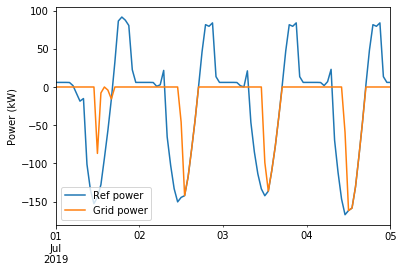

In [20]:
# Grid power
# Ref power: the grid power if the energy network is not intergrated with the distributed battery and the electric vehicles
time_before = '2019-07-1'
time_after = '2019-07-5'
(states['buildingLoad'] - 0.95*states['reGeneration']).truncate(before=time_before, after=time_after).plot(ylabel='Power (kW)',label='Ref power',legend = True)
rewards['gridLoad'].truncate(before=time_before, after=time_after).plot(label='Grid power',legend = True)

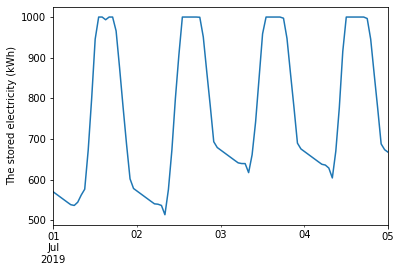

In [21]:
# Electricity stored in the distributed battery (not vehicle batteries)
states['battery_left'].truncate(before='2019-07-1', after='2019-07-5').plot(ylabel='The stored electricity (kWh)')

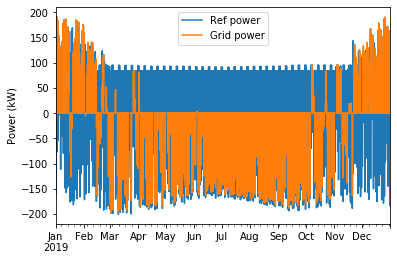

In [22]:
# Hourly grid power
# Ref power: the grid power if the energy network is not integrated with the distributed battery and electric vehicles
(states['buildingLoad'] - 0.95*states['reGeneration']).plot(ylabel='Power (kW)',label='Ref power',legend = True)
(rewards['gridLoad']).plot(label='Grid power',legend = True)

## Energy independence

In [23]:
energyIndep = (1 - rewards.loc[rewards['gridLoad'] > 0, ['gridLoad']]['gridLoad'].sum()/(states['buildingLoad'].sum()+comments['totalVehicleCharge'].sum()))*100
print(f'{energyIndep:.2f}% of the network energy demand (buildings and vehicles) is covered by the renewable and energy-storage systems.')

81.88% of the network energy demand (buildings and vehicles) is covered by the renewable and energy-storage systems.


## Net energy consumption and carbon reduction

In [28]:
carbonFac_ele = 0.386 # kg CO2 per kWh of grid electricity
carbonFac_gas = 18.74 # kg CO2 per gallon of gasoline for vehicles
gasolineEff = 25.7 * 1.609 # km per gallon of gasoline for normal vehicle transportation 
vehicleEff = 0.15 # kWh per km for transportation, make sure this value is the same as that of cruiseEff in the vehicle input csv file

grid_importEle = rewards.loc[rewards['gridLoad'] > 0, ['gridLoad']]['gridLoad'].sum()
grid_exportEle = rewards.loc[rewards['gridLoad'] < 0, ['gridLoad']]['gridLoad'].sum()

gridEle = rewards['gridLoad'].sum()*step_h
buildDem = states['buildingLoad'].sum()*step_h
vehicleDem = comments['totalVehicleCharge'].sum()*step_h
carbonEmis =  gridEle * carbonFac_ele
carbonRedu = (buildDem+vehicleDem - gridEle) * carbonFac_ele

totalDistance = vehicleDem/vehicleEff
carbonRedu_veh = totalDistance/gasolineEff * carbonFac_gas
carbonTotal = carbonRedu + carbonRedu_veh 

print(f'Annual net grid electricity consumption:{gridEle:.2f} kWh.')
print(f'Annual net carbon emission: {carbonEmis:.2f} kg.')
print(f'Annual carbon reduction by deploying renewable and energy storage systems: {carbonRedu:.2f} kg.')
print(f'Annual carbon reduction by using electricity instead of gasoline for transportation: {carbonRedu_veh:.2f} kg.')
print(f'Total annual carbon reduction: {carbonTotal:.2f} kg.')

if gridEle <= 0:
    print('The energy network has actualized zero carbon emission!')
else:
    print('The energy network has NOT actualized zero carbon emission!')


Annual net grid electricity consumption:-48606.13 kWh.
Annual net carbon emission: -18761.97 kg.
Annual carbon reduction by deploying renewable and energy storage systems: 128458.76 kg.
Annual carbon reduction by using electricity instead of gasoline for transportation: 63828.25 kg.
Total annual carbon reduction: 192287.00 kg.
The energy network has actualized zero carbon emission!


## Grid Flexibility

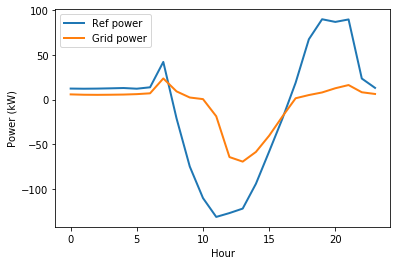

In [29]:
# Mean hourly grid power
buildingLoad = states['buildingLoad'].groupby(states.index.hour).mean()
reGeneration = states['reGeneration'].groupby(states.index.hour).mean()
gridPower = rewards['gridLoad'].groupby(rewards.index.hour).mean()

(buildingLoad - 0.95*reGeneration).truncate(before='0', after='24').plot(lw=2, xlabel='Hour', ylabel='Power (kW)',label='Ref power',legend = True)
gridPower.truncate(before='0', after='24').plot(lw=2, label='Grid power',legend =True)

#gridPower

In [30]:
gridImport = rewards.loc[rewards['gridLoad'] > 0, ['gridLoad']]
gridImport_time = gridImport['gridLoad'].count()*step_h
gridImport_power = gridImport['gridLoad'].mean()

print(f'Annual hours of importing electricity from the local power grid:{gridImport_time:.2f} h.')
print(f'Average grid-import power: {gridImport_power:.2f} kW.')

gridExport = rewards.loc[rewards['gridLoad'] < 0, ['gridLoad']]
gridExport_time = gridExport['gridLoad'].count()*step_h
gridExport_power = gridExport['gridLoad'].mean()

print(f'Annual hours of exporting electricity from the local power grid:{gridExport_time:.2f} h.')
print(f'Average grid-export power: {gridExport_power:.2f} kW.')

Annual hours of importing electricity from the local power grid:1061.00 h.
Average grid-import power: 48.54 kW.
Annual hours of exporting electricity from the local power grid:1140.00 h.
Average grid-export power: -87.82 kW.
